In [1]:
import numpy as np
from transformers import LayoutLMTokenizer, LayoutLMForTokenClassification, AdamW
from datasets import load_dataset, Dataset, Features, Sequence, ClassLabel, Value, Array2D
import torch
from PIL import Image, ImageDraw, ImageFont

from tqdm.notebook import tqdm

In [2]:
dataset = load_dataset("nielsr/funsd")

id2label = ["O", "B-HEADER", "I-HEADER", "B-QUESTION", "I-QUESTION", "B-ANSWER", "I-ANSWER"]
label2id = {l:i for i, l in enumerate(id2label)}
label2id

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label))

model.to(device);

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

# Data Preparation

In [4]:
def encode_training_example(example, max_seq_length=512):
    token_boxes = []
    aligned_labels = []
    for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
        aligned_labels.append(label)
        aligned_labels.extend([-100 for _ in range(len(word_tokens)-1)])

    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
        aligned_labels = aligned_labels[:(max_seq_length - special_tokens_count)]
        
    aligned_labels = [0] + aligned_labels + [0]
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(" ".join(example['words']), padding='max_length', truncation=True)
    
    pad_token_box = [0, 0, 0, 0]
    padding_length = max_seq_length - len(tokenizer(' '.join(example['words']), truncation=True)["input_ids"])
    token_boxes += [pad_token_box] * padding_length
    aligned_labels += [0] * padding_length
 
    encoding['bboxes'] = token_boxes
    encoding['ner_tags'] = aligned_labels
    
    del example['id']
    
    return encoding

training_features = Features({
    'input_ids': Sequence(Value(dtype='int64')),
    'bboxes': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'ner_tags': Sequence(ClassLabel(names=id2label)),
    'image_path': Value(dtype='string'),
    'words': Sequence(Value(dtype='string')),
})

def training_dataloader_from_dataset(dataset):
    encoded_data = dataset.map(encode_training_example, features=training_features)
    encoded_data.set_format(
        type='torch', columns=['input_ids', 'bboxes', 'attention_mask', 'token_type_ids', 'ner_tags']
    )
    dataloader = torch.utils.data.DataLoader(encoded_data, batch_size=1, shuffle=True)
    batch = next(iter(dataloader))
    
    return dataloader

In [5]:
train_dataloader = training_dataloader_from_dataset(dataset['train'])
valid_dataloader = training_dataloader_from_dataset(dataset['test'])

  0%|          | 0/149 [00:00<?, ?ex/s]

  0%|          | 0/50 [00:00<?, ?ex/s]

# Training

In [6]:
optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 10


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    model.train()
    for batch in tqdm(train_dataloader):
        labels = batch["ner_tags"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bboxes"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        labels = batch["ner_tags"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bboxes"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        validation_loss += loss.item()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])

Epoch: 0


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 74.46157360821962


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 18.58324915356934
Epoch: 1


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 35.18854793719947


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 15.177493505179882
Epoch: 2


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 24.003869542852044


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 15.249610170722008
Epoch: 3


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 14.74951477907598


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 15.104529522359371
Epoch: 4


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 10.66637287195772


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 16.62420634739101
Epoch: 5


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 8.858170608058572


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 18.63921938277781
Epoch: 6


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 5.466435657814145


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 18.816453026607633
Epoch: 7


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 4.566339677781798


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 19.594575964845717
Epoch: 8


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 3.578613854770083


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 21.147426337003708
Epoch: 9


  0%|          | 0/149 [00:00<?, ?it/s]

Training Loss: 2.6279990937910043


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 20.51657611131668


In [7]:
model.save_pretrained('saved_model/')

# Inference

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMForTokenClassification.from_pretrained("saved_model")
model.to(device);

In [9]:
labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {v: k for v, k in enumerate(labels)}
label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

In [10]:
query_index = 0
words = dataset['test'][query_index]['words']
normalized_word_boxes = dataset['test'][query_index]['bboxes']

In [11]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
    
def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label    
    
img = Image.open(dataset['test'][query_index]['image_path'])    
W, H = img.size    
bboxes = [unnormalize_box(box, W, H) for box in normalized_word_boxes]

In [12]:
token_boxes = []
for word, box in zip(words, normalized_word_boxes):
    word_tokens = tokenizer.tokenize(word)
    token_boxes.extend([box] * len(word_tokens))
# add bounding boxes of cls + sep tokens
token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

encoding = tokenizer(" ".join(words), return_tensors="pt")
bbox = torch.tensor([token_boxes]).to(device)

outputs = model(
    input_ids=encoding["input_ids"].to(device),
    bbox=bbox,
    attention_mask=encoding["attention_mask"].to(device),
    token_type_ids=encoding["token_type_ids"].to(device),
)

preds = torch.nn.functional.softmax(outputs.logits, dim=2).cpu().detach().numpy()
preds_idx = preds.argmax(axis=2)[0]
preds_labels = [labels[idx] for idx in preds_idx]

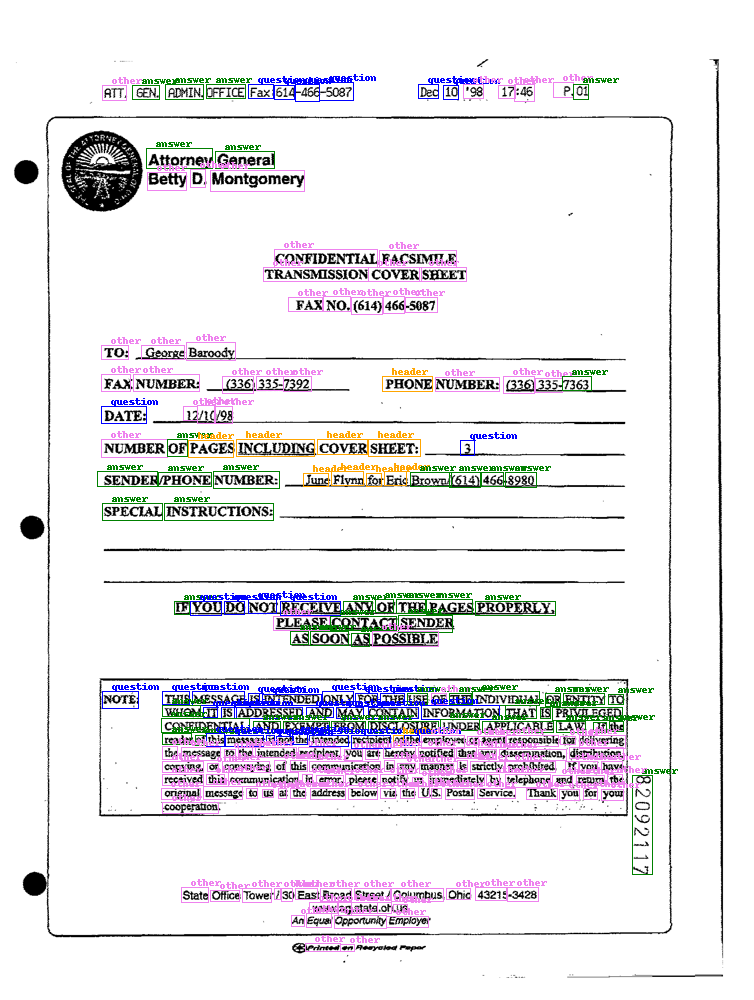

In [13]:
img_rgb = img.convert('RGB')
draw = ImageDraw.Draw(img_rgb)
font = ImageFont.load_default()

for label, box in zip(preds_labels, bboxes):
    label = iob_to_label(label).lower()
    draw.rectangle(box, outline=label2color[label])
    draw.text((box[0]+10, box[1]-10), text=label, fill=label2color[label], font=font)
img_rgb